# Sale Price Anaysis Notebook

## Objectives

* Data Exploration using ProfileReport
* Correlation and PPS Analysis
* Create correlation plots for the streamlit app

## Inputs

* outputs/datasets/collection/house_prices_records.csv 

## Outputs

* Generate correlation plots to be included in the streamlit app 


---

In [28]:
# import all necessary packages and libraries for the notebook
import os
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
sns.set(style="whitegrid")


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [29]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-PP5'

# Load collected data

In [30]:
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# Exploratory Data Analysis (EDA)

We use ProfileReport to get more familiar with the dataset. It will tell use variable types and distribution, missing data levels, etc.

In [ ]:
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

The report on the data set reveals that of the 24 columns, 20 contain numerical values and 4 text/categorical values. A closer look at the detailed information on each variable shows that two of the numerical variables, OverallCond and OverallQual, are also categorical data, which are encoded numerically. Overall approximately 10% of data are missing.

# Correlation and PPS Analysis

We carry out an initial assessment of the relationship between the different variables/features/data. We use custom functions from the CI Walkthrough project 2. First we look at the spearman and pearson correlations specifically as they relate to Sale Price.

In [ ]:
corr_spearman = df.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
corr_spearman

In [ ]:
corr_pearson = df.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
corr_pearson

The most correlated variables (correlation of 0.6 or more) considering both spearman and pearson correlations are: 'OverallQual', 'GrLivArea', 'YearBuilt', 'GarageArea', 'TotalBsmtSF', and '1stFlrSF'. 

We now look at a more extensive study of correlations over the whole field of variables.


In [ ]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


We use CalculateCorrAndPPS function to calculate Correlations and Predictive Power Score.

In [ ]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

In [ ]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.3, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot = 10)

# Plotting the most correlated variables against Sale Price

In [31]:
corr_spearman = df.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
corr_spearman

OverallQual      0.809829
GrLivArea        0.731310
YearBuilt        0.652682
GarageArea       0.649379
TotalBsmtSF      0.602725
GarageYrBlt      0.593788
1stFlrSF         0.575408
YearRemodAdd     0.571159
OpenPorchSF      0.477561
LotArea          0.456461
MasVnrArea       0.421309
LotFrontage      0.409076
BsmtFinSF1       0.301871
2ndFlrSF         0.298809
WoodDeckSF       0.252176
BedroomAbvGr     0.229527
EnclosedPorch   -0.215010
BsmtUnfSF        0.185197
OverallCond     -0.129325
Name: SalePrice, dtype: float64

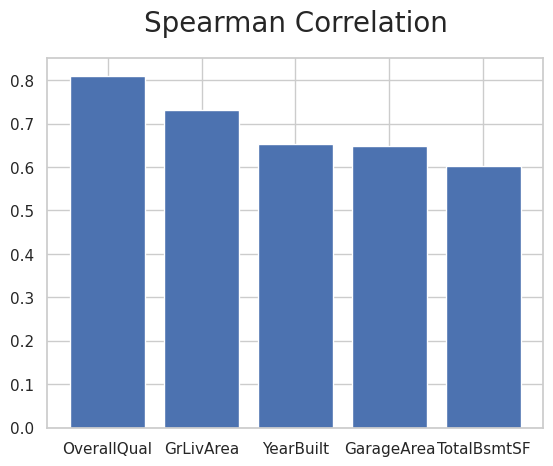

In [32]:
plt.bar(x=corr_spearman[:5].index, height=corr_spearman[:5])
plt.title("Spearman Correlation", fontsize=20, y=1.05)
plt.show()

In [33]:
corr_pearson = df.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
corr_pearson

OverallQual      0.790982
GrLivArea        0.708624
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
BsmtFinSF1       0.386420
LotFrontage      0.351799
2ndFlrSF         0.322335
OpenPorchSF      0.315856
LotArea          0.263843
WoodDeckSF       0.252027
BsmtUnfSF        0.214479
EnclosedPorch   -0.176458
BedroomAbvGr     0.161901
OverallCond     -0.077856
Name: SalePrice, dtype: float64

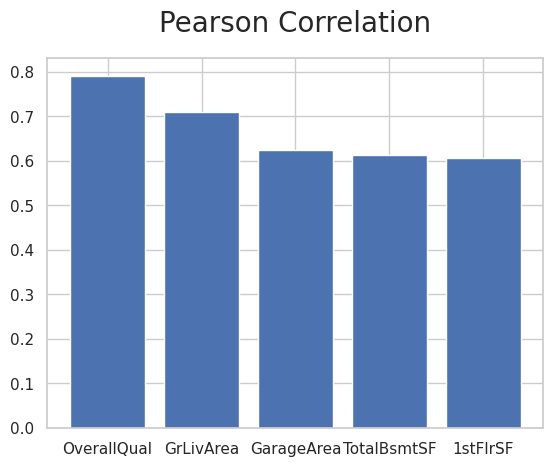

In [34]:
plt.bar(x=corr_pearson[:5].index, height=corr_pearson[:5])
plt.title("Pearson Correlation", fontsize=20, y=1.05)
plt.show()

In [35]:
top_n = 5
vars_to_study = set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())
vars_to_study 

{'1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt'}

In [36]:
df_eda = df.filter(list(vars_to_study) + ['SalePrice'])
df_eda.head(3)

,1stFlrSF,TotalBsmtSF,GrLivArea,YearBuilt,GarageArea,OverallQual,SalePrice
0,856,856,1710,2003,548,7,208500
1,1262,1262,1262,1976,460,6,181500
2,920,920,1786,2001,608,7,223500


Plot each variable as a scatter plot against the sale price.

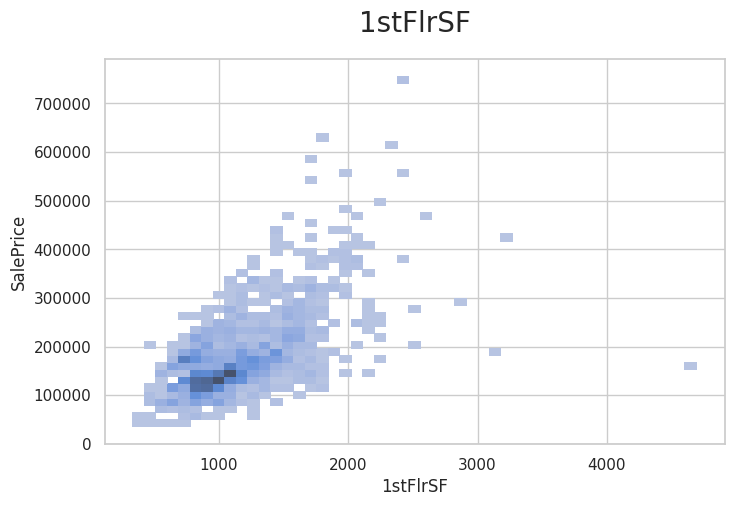

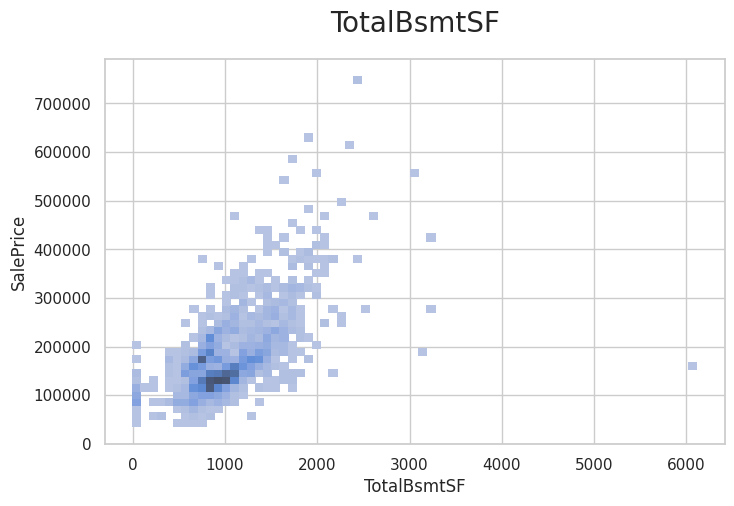

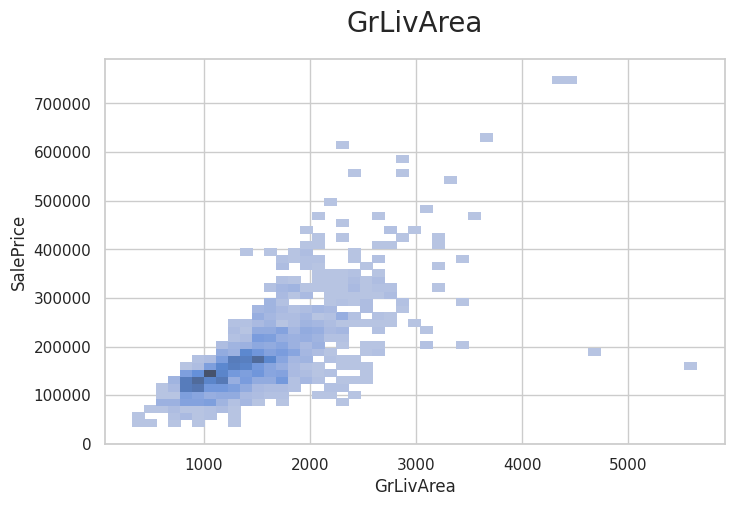

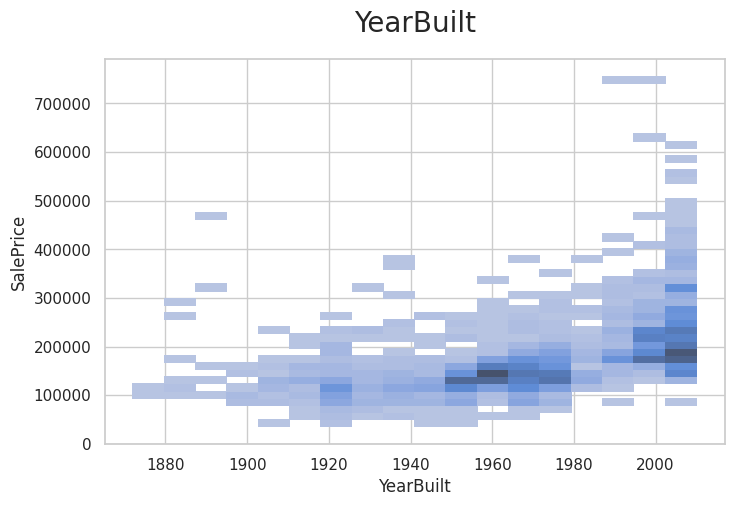

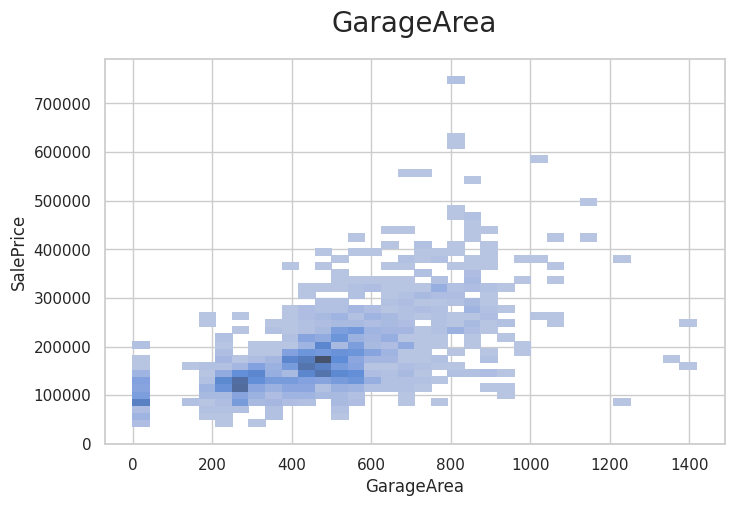

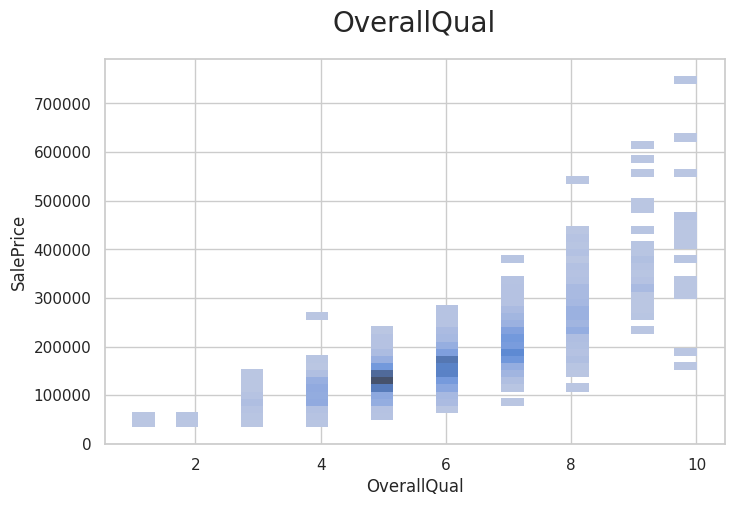

In [37]:
def correlation_to_sale_price_hist(df, vars_to_study):
    """ Display correlation plot between variables and sale price """
    target_var = 'SalePrice'
    for col in vars_to_study:
        fig, axes = plt.subplots(figsize=(8, 5))
        axes = sns.histplot(data=df, x=col, y=target_var)
        plt.title(f"{col}", fontsize=20, y=1.05)
        plt.show()
        print("\n\n")

correlation_to_sale_price_hist(df_eda, vars_to_study)

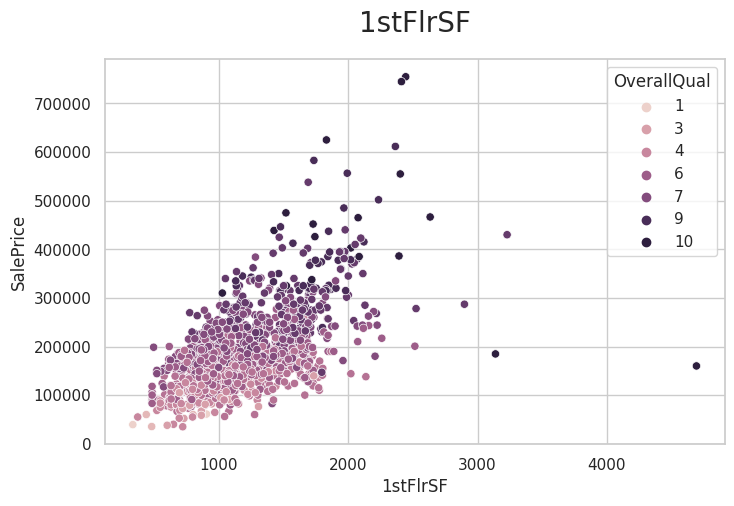

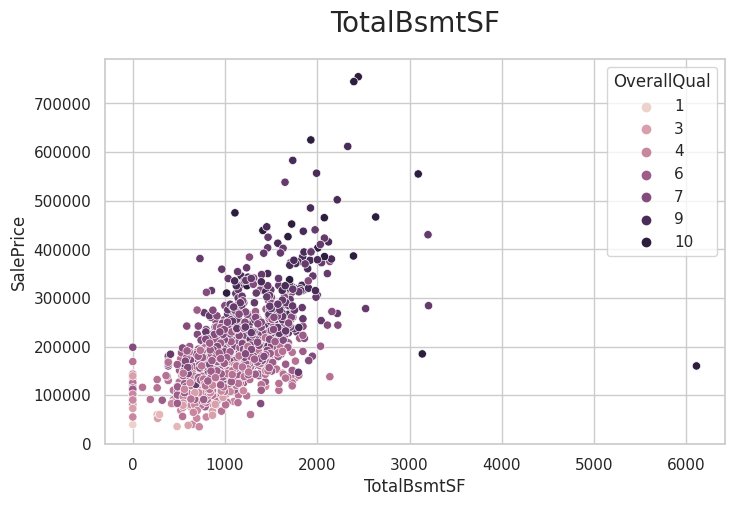

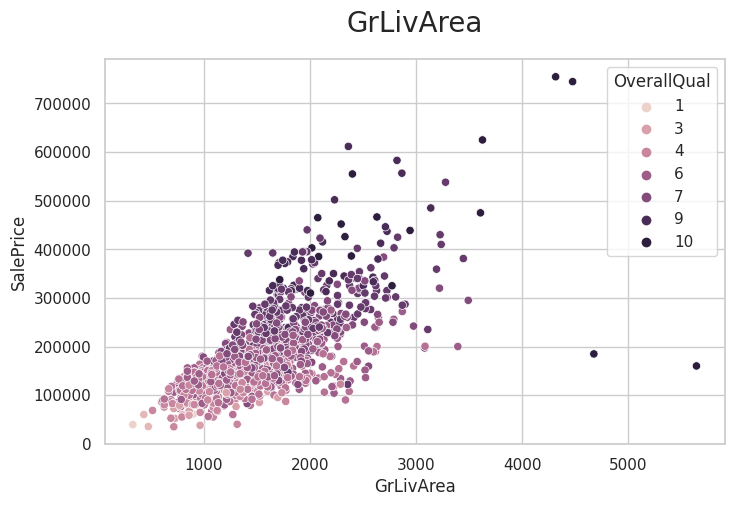

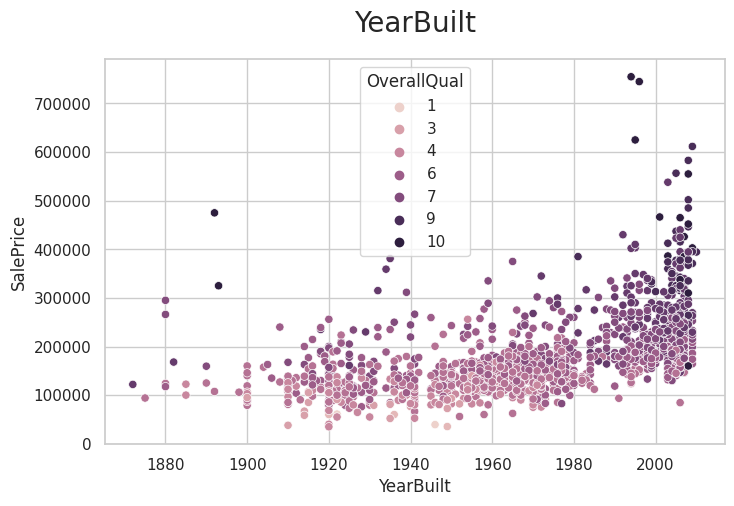

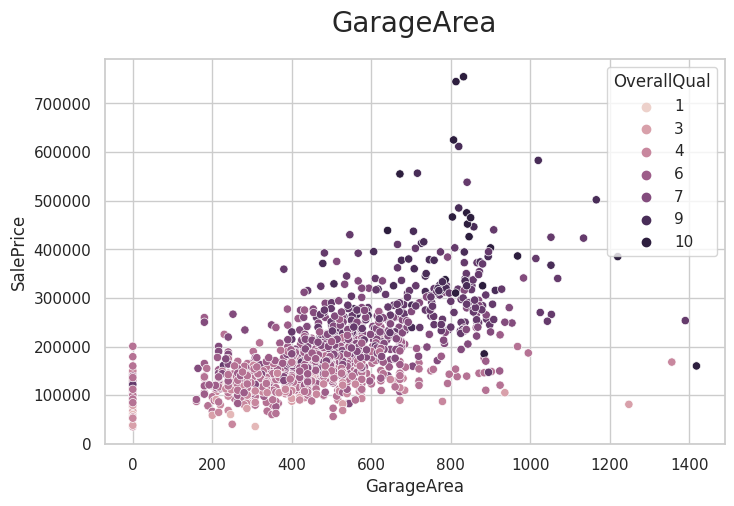

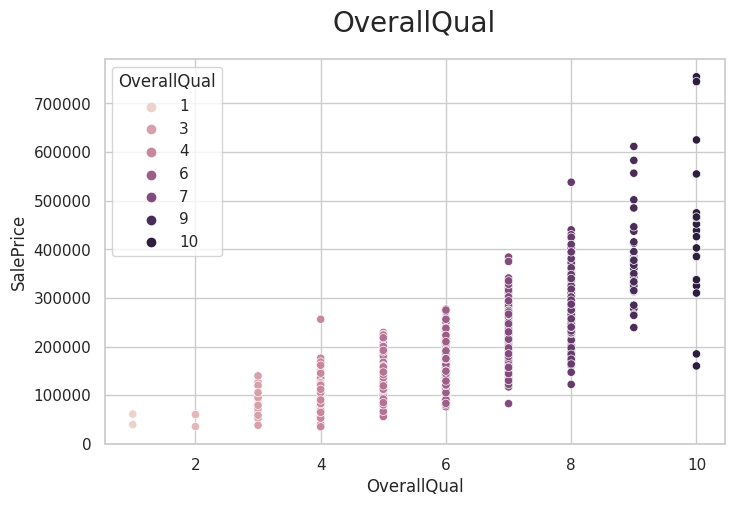

In [38]:
def correlation_to_sale_price_scat(df, vars_to_study):
    """  scatterplots of variables vs SalePrice """
    target_var = 'SalePrice'
    for col in vars_to_study:
        fig, axes = plt.subplots(figsize=(8, 5))
        axes = sns.scatterplot(data=df, x=col, y=target_var, hue='OverallQual')
        plt.title(f"{col}", fontsize=20, y=1.05)
        plt.show()
        print("\n\n")

correlation_to_sale_price_scat(df_eda, vars_to_study)

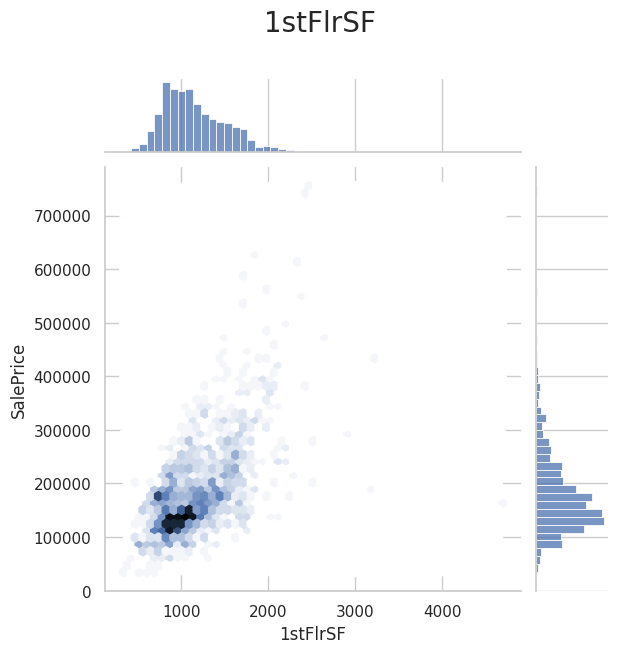

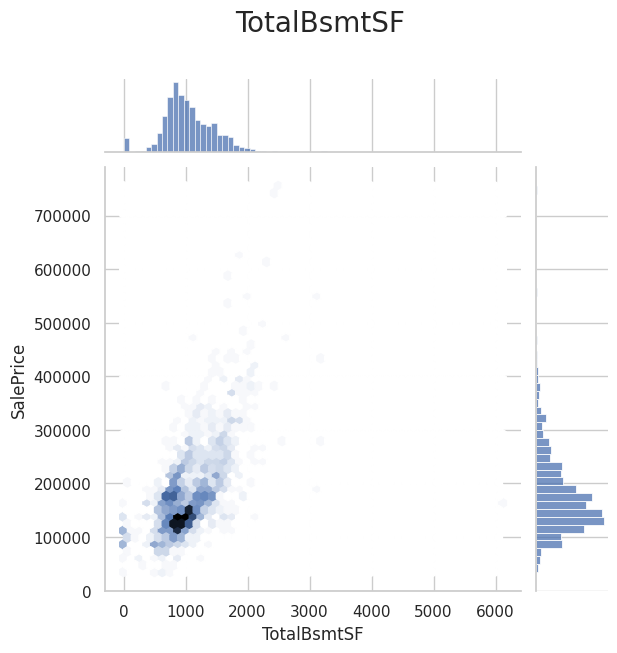

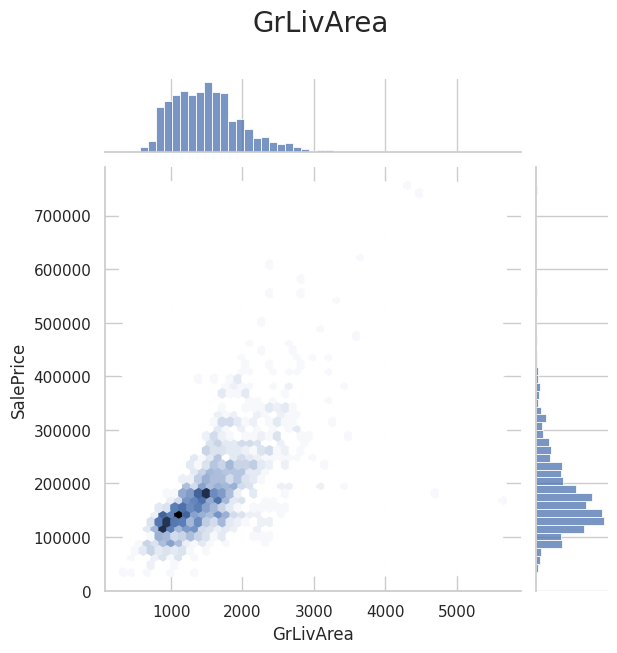

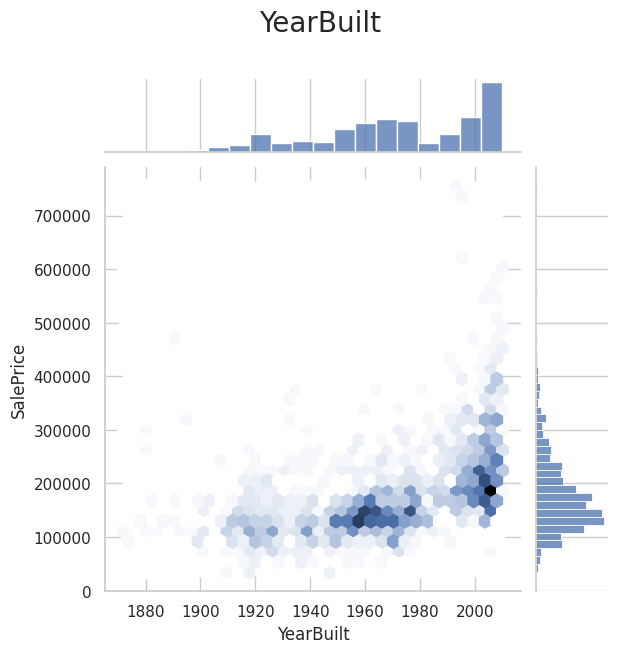

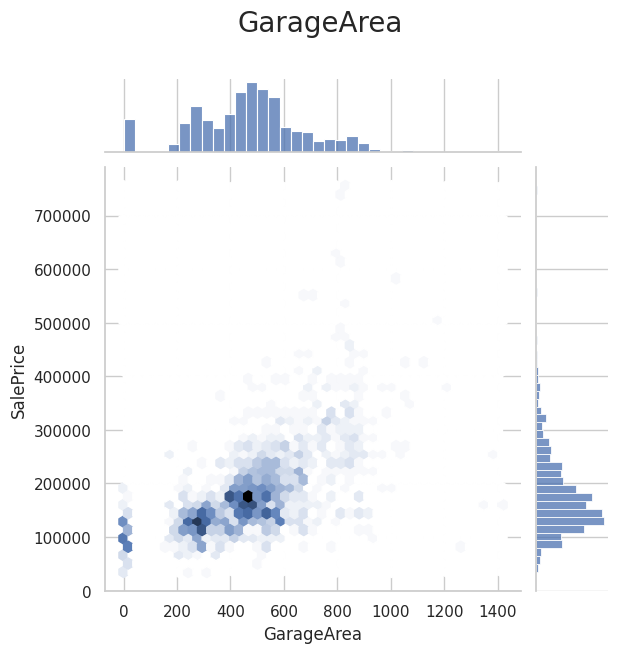

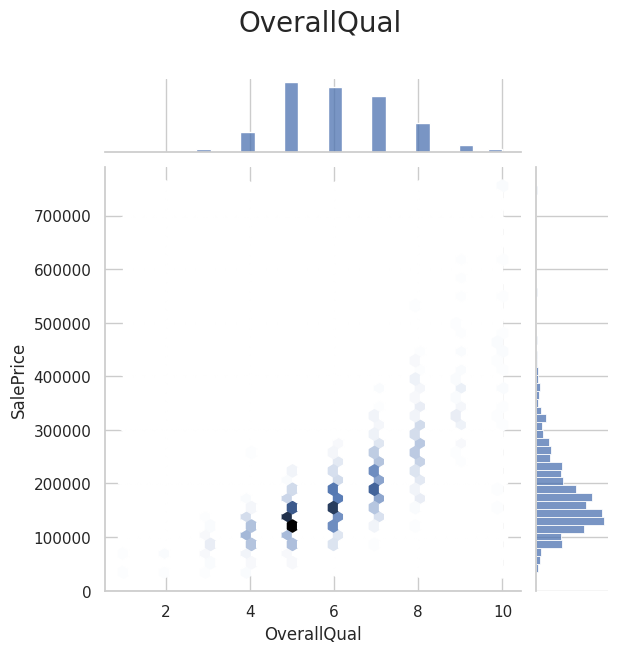

In [39]:
def correlation_to_sale_price_joint(df, vars_to_study):
    """  Joint plots of variables vs SalePrice """
    target_var = 'SalePrice'
    for col in vars_to_study:
        x, y, hue = col, target_var, 'OverallQual'
        sns.jointplot(data=df, x=x, y=y, kind='hex')
        # sns.jointplot(data=df, x=x, y=y, hue=hue)
        plt.title(f"{col}", fontsize=20, y=1.3, x=-3)
        plt.show()
        print("\n\n")


correlation_to_sale_price_joint(df_eda, vars_to_study)

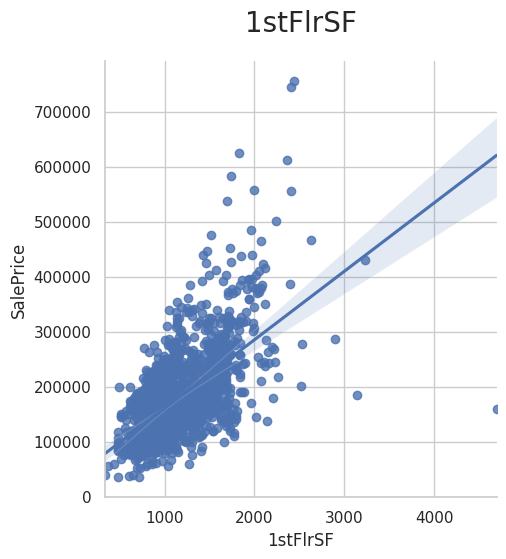

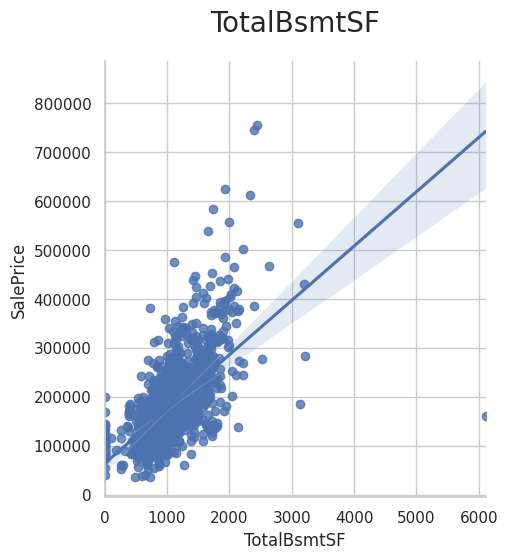

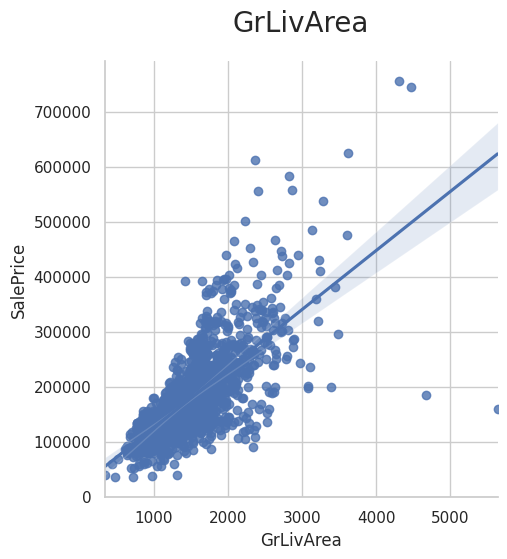

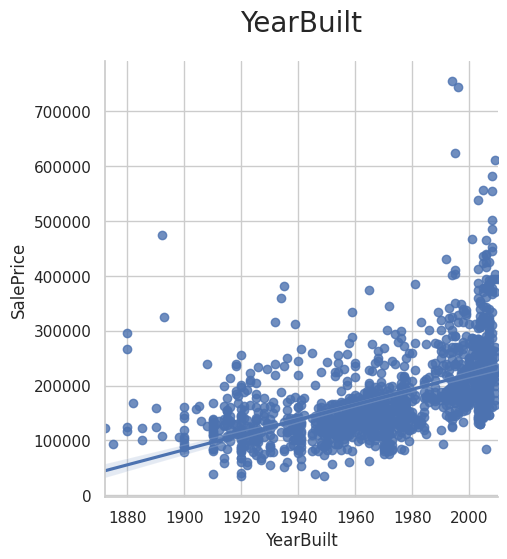

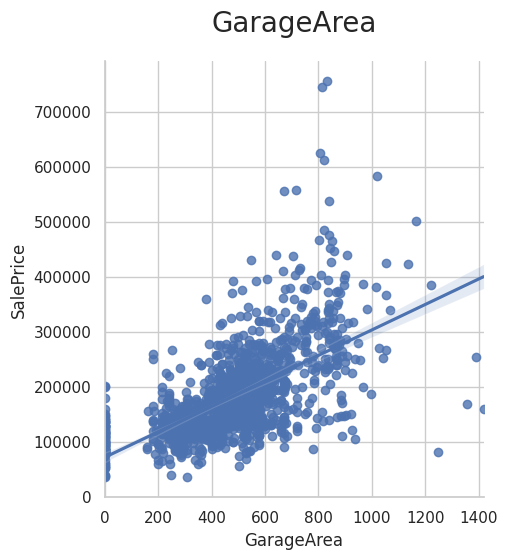

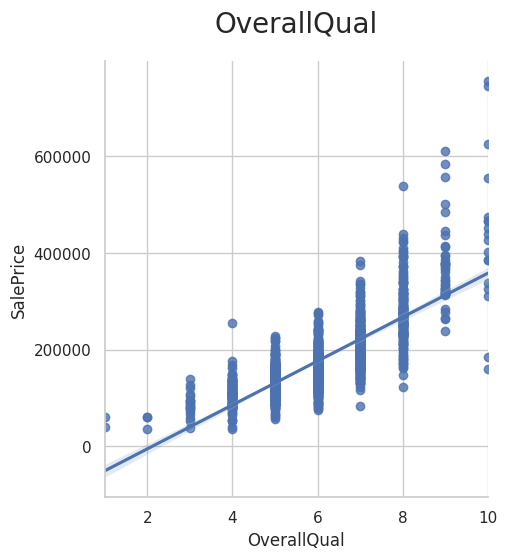

In [40]:
def correlation_to_sale_price_lm(df, vars_to_study):
    """  Joint plots of variables vs SalePrice """
    target_var = 'SalePrice'
    for col in vars_to_study:
        # fig, axes = plt.subplots(figsize=(8, 5))
        sns.lmplot(data=df, x=col, y=target_var)
        plt.title(f"{col}", fontsize=20, y=1.05)
        plt.show()
        print("\n\n")

correlation_to_sale_price_lm(df_eda, vars_to_study)

We have created a variety of plot which show the illustrate the relationship between the Sale Price and the most correlated variables. We will include a selection of these in the final deployed app to fullfill the first business requirement.

---

# Conclusion

* Over all quality has the biggest effect on the Sale Price
* Generally, larger square footage of the 1st Floor, Ground Living Area, Garage Area and Basement, is an indicator of a higher sale price.
* Newer home tend to have a higher sale price.